<a href="https://colab.research.google.com/github/saturnsz/Topik-Klasifikasi-Kuliner-Nusantara-Indonesian-Chicken-Dishes-/blob/main/KlasifikasiUSH2(MobileNetV2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import numpy as np
import cv2

**Pemuatan Data**

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/train/train'
TEST_DIR = '/content/drive/MyDrive/test/test'
MIN_RESOLUTION = (50, 50) # Resolusi minimum (Lebar x Tinggi)

# List untuk menampung data yang akan diproses selanjutnya
train_image_paths = []
train_image_labels = []
test_image_paths = []
class_names = []

**Ayam Bakar**

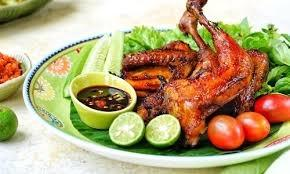

**Ayama Pop**

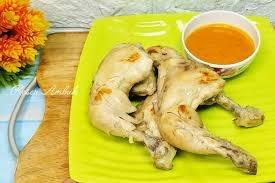

**Ayam Goreng**

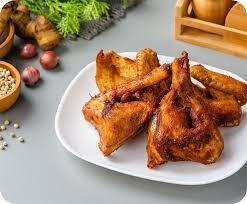

**Ayam Betutu**

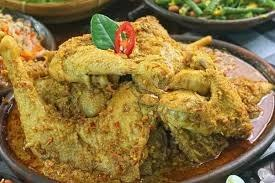

In [ ]:
def load_and_clean_data(data_dir, is_train_set=True):
    """
    Memuat path gambar, label, dan membersihkan gambar rusak/low-res secara eksplisit.
    """
    paths_list = []
    labels_list = []
    current_class_names = []
    corrupted_count = 0
    low_res_count = 0

    print(f"\n--- Memproses Direktori: {data_dir} (Set: {'Train' if is_train_set else 'Test'}) ---")

    # Tentukan subfolder yang akan diiterasi
    if is_train_set:
        subfolders = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    else:
        # Untuk data test, kita asumsikan semua gambar ada di folder 'test' itu sendiri
        # atau di subfolder, tergantung bagaimana data test Anda disiapkan.
        # Kita akan iterasi di folder test saja untuk saat ini, jika test tidak berlabel.
        subfolders = [''] # Folder root test

    for subfolder_name in subfolders:
        class_name = subfolder_name if is_train_set else 'unknown' # Hanya train yang punya label

        if is_train_set:
            current_class_names.append(class_name)

        folder_path = os.path.join(data_dir, subfolder_name)

        # Cari semua file .jpg di dalam folder
        files = glob.glob(os.path.join(folder_path, '*.jpg'))

        for file_path in files:

            # 1. Pemeriksaan Gambar Rusak (cv2.imread)
            img = cv2.imread(file_path)

            if img is None:
                corrupted_count += 1
                # print(f"  [Dihapus] Rusak: {file_path}")
                continue

            # 2. Pemeriksaan Outlier Resolusi Rendah
            height, width, _ = img.shape

            if width < MIN_RESOLUTION[0] or height < MIN_RESOLUTION[1]:
                low_res_count += 1
                # print(f"  [Dihapus] Low Res ({width}x{height}): {file_path}")
                continue

            # Jika lolos validasi
            paths_list.append(file_path)
            if is_train_set:
                labels_list.append(class_name)

    print(f"Total Sampel Awal Dihapus karena Rusak: {corrupted_count}")
    print(f"Total Sampel Awal Dihapus karena Low-Res: {low_res_count}")

    if is_train_set:
        return np.array(paths_list), np.array(labels_list), current_class_names
    else:
        return np.array(paths_list), None, None

In [ ]:
# A. Muat dan Bersihkan Data TRAIN
train_image_paths, train_image_labels, class_names = load_and_clean_data(TRAIN_DIR, is_train_set=True)

# B. Muat dan Bersihkan Data TEST
test_image_paths, _, _ = load_and_clean_data(TEST_DIR, is_train_set=False)

print("\n--- Ringkasan Hasil Tahap 1 ---")
print(f"1. Kelas yang Ditemukan: {class_names}")
print(f"2. Total Gambar Latih Bersih: {len(train_image_paths)}")
print(f"3. Total Gambar Uji Bersih: {len(test_image_paths)}")


--- Memproses Direktori: /content/drive/MyDrive/train/train (Set: Train) ---
Total Sampel Awal Dihapus karena Rusak: 0
Total Sampel Awal Dihapus karena Low-Res: 0

--- Memproses Direktori: /content/drive/MyDrive/test/test (Set: Test) ---
Total Sampel Awal Dihapus karena Rusak: 0
Total Sampel Awal Dihapus karena Low-Res: 0

--- Ringkasan Hasil Tahap 1 ---
1. Kelas yang Ditemukan: ['Ayam Pop', 'Ayam Betutu', 'Ayam Goreng', 'Ayam Bakar']
2. Total Gambar Latih Bersih: 1086
3. Total Gambar Uji Bersih: 269


**Pra-pemrosesan Data (Preprocessing)**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# 1. Encoding Label Teks ke Numerik
le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_image_labels)
# print(f"Label Mapping: {dict(zip(le.classes_, le.transform(le.classes_))}")

# 2. Pembagian Data Train menjadi Train dan Validation (80:20)
# Stratify=True memastikan pembagian proporsi kelas yang merata
X_train_paths, X_val_paths, y_train_labels, y_val_labels = train_test_split(
    train_image_paths,
    train_labels_encoded,
    test_size=0.2, # 20% untuk Validasi
    random_state=42,
    shuffle=True,
    stratify=train_labels_encoded # Penting untuk menjaga keseimbangan kelas
)

# 3. Konversi label ke format One-Hot Encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train_labels, num_classes=len(class_names))
y_val_one_hot = tf.keras.utils.to_categorical(y_val_labels, num_classes=len(class_names))

print(f"\n--- Pembagian Data (Stratified) ---")
print(f"Gambar Pelatihan: {len(X_train_paths)} ({len(y_train_one_hot)} label)")
print(f"Gambar Validasi: {len(X_val_paths)} ({len(y_val_one_hot)} label)")


--- Pembagian Data (Stratified) ---
Gambar Pelatihan: 868 (868 label)
Gambar Validasi: 218 (218 label)


Encoding Label
Objektif: Mengubah label teks (misalnya, "Ayam Bakar", "Ayam Pop") menjadi nilai numerik unik (misalnya, 0, 1, 2, 3) menggunakan LabelEncoder.

Pembagian Data Pelatihan dan Validasi (Stratified Split)
Membagi dataset pelatihan (train_image_paths) menjadi dua bagian, 80% untuk Pelatihan dan 20% untuk Validasi, memastikan distribusi sampel untuk setiap kelas tetap seimbang (Stratified Split).

Konversi ke One-Hot Encoding
Mengubah label numerik (misalnya, 0) menjadi format vektor biner (One-Hot Encoding) yang diperlukan untuk fungsi loss Categorical Cross-Entropy dalam klasifikasi multi-kelas (misalnya, 0 menjadi [1, 0, 0, 0]).


In [ ]:
# parameter preprocessing
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
# NUM_CLASSES sudah ditentukan sebelumnya

def load_and_preprocess_image(path, label=None, augment=False):
    """Fungsi untuk memuat gambar, mengubah ukuran, dan normalisasi."""

    # Pra-pemrosesan Inti
    # 1. Muat Gambar (TensorFlow way)
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)

    # 2. Ubah Ukuran
    img = tf.image.resize(img, IMAGE_SIZE) # (224, 224)

    # 3. Normalisasi
    img = img / 255.0

    # 4. Augmentasi (Eksplisit Feature Engineering)
    if augment:

        # Rotasi dan Zoom seringkali rumit jika langsung diimplementasikan
        # menggunakan fungsi dasar tf.image dalam tf.data.
        # Kita akan menggunakan Augmentasi sederhana yang pasti didukung:

        # Horizontal Flip
        img = tf.image.random_flip_left_right(img)


        # Penyesuaian Kecerahan/Kontras Acak
        img = tf.image.random_brightness(img, max_delta=0.1) # Sesuaikan kecerahan
        img = tf.image.random_contrast(img, lower=0.9, upper=1.1) # Sesuaikan kontras

    if label is not None:
        return img, label
    return img

# Pembentukan Pipeline
# Membuat TF Datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train_paths, y_train_one_hot))
train_ds = train_ds.map(lambda x, y: load_and_preprocess_image(x, y, augment=True),
                        num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_paths, y_val_one_hot))
val_ds = val_ds.map(lambda x, y: load_and_preprocess_image(x, y, augment=False),
                    num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("\nDataset Latih dan Validasi Kustom siap untuk pelatihan.")


Dataset Latih dan Validasi Kustom siap untuk pelatihan.


**Pembentukan Model MobileNetV2**

In [ ]:
# Fase 1
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Model Configuration
BASE_MODEL_TRAINABLE_LAYERS = 0 # Mulai dengan membekukan semua lapisan Base Model

# 1. Muat Base Model
base_model = MobileNetV2(
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)

# 2. Atur Lapisan Trainable
base_model.trainable = (BASE_MODEL_TRAINABLE_LAYERS > 0)

# 3. Tambahkan Lapisan Klasifikasi (Custom Head)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Regulasi Eksplisit (Corrected: apply dropout to x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 4. Compile Model (Fase 1: Melatih Custom Head Saja)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks Eksplisit
checkpoint_filepath = 'best_model.weights.h5' # Corrected filepath
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5, # 5 epochs tanpa perbaikan
    restore_best_weights=True
)

print("\nModel siap. Akan memulai Fase 1: Pelatihan Custom Head.")

# 5. Pelatihan Model (Fase 1: Training Custom Head)
# Pelatihan harus disesuaikan dengan kebutuhan Anda
history_phase_1 = model.fit(
    train_ds,
    epochs=10, # Misalnya 10 epochs
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

print("\nPelatihan Fase 1 Selesai. Hasil Bobot Terbaik Disimpan.")


Model siap. Akan memulai Fase 1: Pelatihan Custom Head.
Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.4839 - loss: 1.4085 - val_accuracy: 0.6972 - val_loss: 0.7270
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.7287 - loss: 0.6776 - val_accuracy: 0.7477 - val_loss: 0.6234
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7728 - loss: 0.5533 - val_accuracy: 0.7890 - val_loss: 0.5949
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8214 - loss: 0.4502 - val_accuracy: 0.8073 - val_loss: 0.5528
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8413 - loss: 0.3930 - val_accuracy: 0.7523 - val_loss: 0.7504
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8571 - loss: 0.3666 - val_accuracy: 0.7982 - val_loss: 0.5637
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9102 - loss: 0.2776 - val_accuracy: 0.7936 - val_loss: 0.6024
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy:

**Fine-Tuning Eksplisit**

meningkatkan performa model secara substansial

In [ ]:
# Fase 2
# 1. Buka blokir Base Model (Fine-Tuning)
base_model.trainable = True

# 2. Bekukan lapisan awal yang berisi fitur umum
# Umumnya, kita membekukan sekitar 50-70% dari lapisan awal
# Misalnya, MobileNetV2 punya banyak lapisan, kita akan membekukan lapisan awal
# Kita akan unfreeze 50 lapisan terakhir
fine_tune_at = len(base_model.layers) - 50 # Misalnya 50 lapisan terakhir

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 3. Compile Ulang Model dengan Learning Rate yang Lebih Kecil
# Learning Rate yang kecil mencegah bobot pre-trained rusak terlalu cepat
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Sangat kecil!
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nModel siap. Akan memulai Fase 2: Fine-Tuning pada {len(model.trainable_variables)} variabel yang dapat dilatih.")

# 4. Pelatihan Model (Fase 2: Fine-Tuning)
# Lanjutkan pelatihan dari bobot terbaik sebelumnya
history_phase_2 = model.fit(
    train_ds,
    epochs=20, # Lanjutkan selama 10-20 epochs lagi
    initial_epoch=history_phase_1.epoch[-1], # Mulai dari epoch terakhir Fase 1
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

print("\nPelatihan Fine-Tuning Selesai. Bobot terbaik telah digunakan.")


Model siap. Akan memulai Fase 2: Fine-Tuning pada 55 variabel yang dapat dilatih.
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.6622 - loss: 0.8728 - val_accuracy: 0.7615 - val_loss: 0.6077
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7453 - loss: 0.6497 - val_accuracy: 0.7477 - val_loss: 0.6681
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7975 - loss: 0.5372 - val_accuracy: 0.7339 - val_loss: 0.7164
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8112 - loss: 0.4724 - val_accuracy: 0.7156 - val_loss: 0.7520
Epoch 13/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8296 - loss: 0.4579 - val_accuracy: 0.7110 - val_loss: 0.7860
Epoch 14/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8507 - loss: 0.4220 - val_accuracy: 0.7110 - val_loss: 0.7973

Pelatihan Fine-Tuning Selesai. Bobot terbaik telah digunakan.


**Tahap Pembentukan Dataset Pengujian**

memastikan data dimuat dan dipra-proses secara konsisten dan efisien

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
# Pastikan model (Model) dan IMAGE_SIZE sudah didefinisikan dari langkah sebelumnya

# --- 1. Persiapan Data Test ---
# Buat TF Dataset dari path gambar test
# Kita hanya perlu path, karena tidak ada label (y=None)
test_ds = tf.data.Dataset.from_tensor_slices(test_image_paths) # Inisialisasi Dataset dari Paths


# Terapkan fungsi preprocessing tanpa augmentasi
# Fungsi load_and_preprocess_image harus mampu menangani label None
# load_and_preprocess_image(path, label=None, augment=False)
# Menerapkan langkah-langkah resize dan Normalisasi
test_ds = test_ds.map(lambda x: load_and_preprocess_image(x, augment=False),
                      num_parallel_calls=tf.data.AUTOTUNE)

# Batching dataset
# Shuffle=False penting untuk menjaga urutan prediksi
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Dataset Pengujian siap dengan {len(test_image_paths)} sampel.")

Dataset Pengujian siap dengan 269 sampel.


**Inferensi (Inference)**

In [ ]:
# Asumsikan Anda telah mendefinisikan arsitektur model (model) seperti di langkah sebelumnya
# dan bobot terbaik disimpan di 'best_model.h5'
try:
    # Memuat bobot terbaik yang disimpan oleh ModelCheckpoint
    model.load_weights(checkpoint_filepath)
    print("Bobot terbaik telah berhasil dimuat kembali dari checkpoint.")
except Exception as e:
    print(f"Gagal memuat bobot model. Menggunakan bobot saat ini. Error: {e}")

# --- 3. Prediksi ---

print("Membuat prediksi pada set Pengujian...")
# Melakukan prediksi pada seluruh dataset test
predictions = model.predict(test_ds)

# Mengkonversi hasil prediksi (probabilitas Softmax) menjadi label kelas (indeks)
# np.argmax mengambil indeks probabilitas tertinggi
predicted_labels_index = np.argmax(predictions, axis=1)

# Mengkonversi indeks kelas menjadi nama kelas (teks)
# Gunakan le.classes_ (dari LabelEncoder yang digunakan di langkah sebelumnya)
predicted_class_names = le.inverse_transform(predicted_labels_index)

print("\nPrediksi selesai.")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 112 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Bobot terbaik telah berhasil dimuat kembali dari checkpoint.
Membuat prediksi pada set Pengujian...
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step

Prediksi selesai.


In [ ]:
y_true = y_val_labels
predictions_val = model.predict(val_ds)
predicted_val_labels_index = np.argmax(predictions_val, axis=1)

print("\n--- 4. Laporan Klasifikasi (Hanya Ilustrasi/Validasi) ---")
print(classification_report(y_true, predicted_val_labels_index, target_names=class_names))

print("\n--- Matriks Kebingungan ---")
cm = confusion_matrix(y_true, predicted_val_labels_index)
print(cm)


7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step

--- 4. Laporan Klasifikasi (Hanya Ilustrasi/Validasi) ---
              precision    recall  f1-score   support

    Ayam Pop       0.81      0.77      0.79        56
 Ayam Betutu       0.81      0.83      0.82        46
 Ayam Goreng       0.73      0.82      0.77        65
  Ayam Bakar       0.93      0.82      0.88        51

    accuracy                           0.81       218
   macro avg       0.82      0.81      0.81       218
weighted avg       0.81      0.81      0.81       218


--- Matriks Kebingungan ---
[[43  3  9  1]
 [ 1 38  7  0]
 [ 6  4 53  2]
 [ 3  2  4 42]]


In [ ]:
import pandas as pd

submission_df = pd.DataFrame({
    'file_path': test_image_paths, # Atau hanya nama file saja
    'predicted_class': predicted_class_names
})

# Anda mungkin perlu menyesuaikan kolom ini sesuai dengan format yang diminta
submission_df['filename'] = submission_df['file_path'].apply(lambda x: os.path.basename(x))
final_submission_df = submission_df[['filename', 'predicted_class']]

# Simpan ke file CSV
submission_filename = 'submission_ayam_nusantara.csv'
final_submission_df.to_csv(submission_filename, index=False)

print(f"\nFile submission berhasil dibuat: {submission_filename}")
print("Contoh 5 baris pertama hasil prediksi:")
print(final_submission_df.head())


File submission berhasil dibuat: submission_ayam_nusantara.csv
Contoh 5 baris pertama hasil prediksi:
  filename predicted_class
0  185.jpg     Ayam Goreng
1  026.jpg        Ayam Pop
2  012.jpg     Ayam Goreng
3  239.jpg        Ayam Pop
4  075.jpg      Ayam Bakar


In [ ]:
import pandas as pd

# 1. Muat file submission Anda
df_submission = pd.read_csv("/content/drive/MyDrive/submission_ayam_nusantara.csv")

# 2. Periksa kolom yang ada
print("Kolom asli:", df_submission.columns.tolist())

# 3. Ganti nama kolom agar sesuai dengan format yang diminta
# Menggunakan asumsi format yang diminta adalah 'Id' dan 'label'
df_submission.rename(columns={
    'filename': 'Id',
    'predicted_class': 'label'
}, inplace=True)

# 4. Pastikan hanya dua kolom yang ada dan urutannya benar
df_final_submission = df_submission[['Id', 'label']]

# 5. Simpan file baru
fixed_submission_filename = 'fixed_final_submission.csv'
df_final_submission.to_csv(fixed_submission_filename, index=False)

print(f"\nFile submission baru (fixed) berhasil dibuat: {fixed_submission_filename}")
print("Pastikan untuk mengunggah file ini!")
print("\n5 baris pertama file baru:")
print(df_final_submission.head())

Kolom asli: ['filename', 'predicted_class']

File submission baru (fixed) berhasil dibuat: fixed_final_submission.csv
Pastikan untuk mengunggah file ini!

5 baris pertama file baru:
        Id        label
0  185.jpg  Ayam Goreng
1  026.jpg     Ayam Pop
2  012.jpg  Ayam Goreng
3  239.jpg     Ayam Pop
4  075.jpg   Ayam Bakar


In [ ]:
import pandas as pd

filename = "/content/fixed_final_submission.csv"

try:
    df_submission = pd.read_csv(filename)

    print(f"Menampilkan Isi File: {filename}")

    # 1. Tampilkan informasi dasar (jumlah baris/kolom)
    print("\n[Informasi Struktur Data]")
    df_submission.info()

    # 2. Tampilkan 10 baris pertama
    print("\n[10 Baris Pertama (Header dan Data)]")
    print(df_submission.head(10))

    # 3. Tampilkan 5 baris terakhir
    print("\n[5 Baris Terakhir]")
    print(df_submission.tail())

    # 4. Verifikasi nilai unik (opsional, untuk memastikan label kelas benar)
    print("\n[Verifikasi Label Kelas Unik]")
    print(df_submission['label'].value_counts())

except FileNotFoundError:
    print(f"ERROR: File '{filename}' tidak ditemukan. Pastikan file berada di direktori yang sama.")
except Exception as e:
    print(f"Terjadi error saat memuat data: {e}")

Menampilkan Isi File: /content/fixed_final_submission.csv

[Informasi Struktur Data]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      269 non-null    object
 1   label   269 non-null    object
dtypes: object(2)
memory usage: 4.3+ KB

[10 Baris Pertama (Header dan Data)]
        Id        label
0  185.jpg  Ayam Goreng
1  026.jpg     Ayam Pop
2  012.jpg  Ayam Goreng
3  239.jpg     Ayam Pop
4  075.jpg   Ayam Bakar
5  010.jpg   Ayam Bakar
6  147.jpg   Ayam Bakar
7  210.jpg     Ayam Pop
8  006.jpg  Ayam Goreng
9  234.jpg  Ayam Goreng

[5 Baris Terakhir]
          Id        label
264  125.jpg  Ayam Goreng
265  250.jpg  Ayam Goreng
266  259.jpg  Ayam Betutu
267  123.jpg  Ayam Goreng
268  182.jpg     Ayam Pop

[Verifikasi Label Kelas Unik]
label
Ayam Goreng    126
Ayam Bakar      61
Ayam Pop        42
Ayam Betutu     40
Name: count, dtype: int64
